In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("Karachi_Property_Dataset.csv")
df.head()

,Price,ID,Address,Bathrooms,Bedrooms,Size/Area,Purpose,Type,Real State Agency,Real State Agent Name
0,PKR7.9 Crore,34881234,"DHA Phase 6, DHA Defence, Karachi, Sindh",4,5,300 Sq. Yd.,For Sale,House,Bukhari Properties,Bukhari Properties Builders
1,PKR1.88 Crore,38292537,"Bahria Town - Precinct 11-A, Bahria Town - Pre...",3,3,150 Sq. Yd.,For Sale,House,Rohan Real Estate,Gul Ahmed
2,PKR2.3 Crore,37292645,"Bahria Town - Precinct 10-A, Bahria Town Karac...",3,3,200 Sq. Yd.,For Sale,House,Z & A Real Estate & Builders,Asim Khaliq
3,PKR12.99 Crore,38291342,"DHA Phase 5, DHA Defence, Karachi, Sindh",6,6,500 Sq. Yd.,For Sale,House,Safeway Estate & Builders,Sikandar Minhas Zubair Khan
4,PKR95 Lakh,37930847,"Bahria Greens, Bahria Town Karachi, Karachi, S...",3,3,75 Sq. Yd.,For Sale,House,Al Waiz Group,Aamir Shahzad Waiz


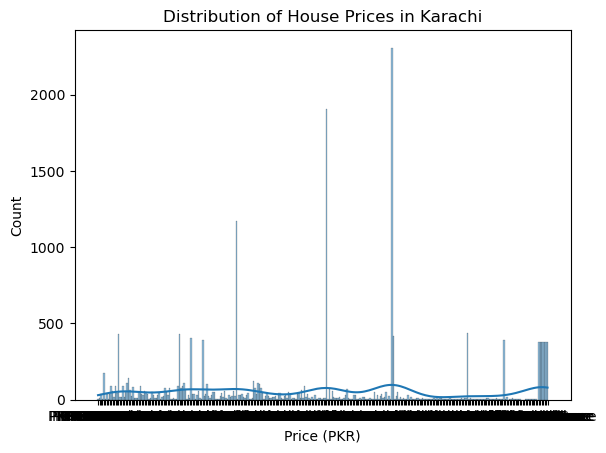

In [3]:
sns.histplot(df["Price"], kde=True)
plt.title("Distribution of House Prices in Karachi")
plt.xlabel("Price (PKR)")
plt.show()

In [4]:
def convert_price(x):
    if pd.isna(x) or str(x).strip().lower() in ["na", "nan", "none", ""]:
        return np.nan
    x = str(x).replace("PKR", "").strip()
    if "Crore" in x:
        return float(x.split()[0]) * 10_000_000
    elif "Lakh" in x:
        return float(x.split()[0]) * 100_000
    else:
        return float(x.split()[0])

df["Price"] = df["Price"].apply(convert_price)

In [5]:
df["Size"] = pd.to_numeric(df["Size/Area"].str.split(" ", expand=True)[0], errors="coerce")
df["Bedrooms"] = pd.to_numeric(df["Bedrooms"], errors="coerce")

In [6]:
df["Bathrooms"] = pd.to_numeric(df["Bathrooms"], errors="coerce") # Keeping this!

In [7]:
#df["Neighborhood"] = df["Address"].str.split(",", expand=True)[1].str.strip() # Using Index 1 for Town

In [8]:
temp_df = df["Address"].str.split(",", expand=True)
df["Neighborhood"] = temp_df[0].str.strip() + " " + temp_df[1].str.strip().fillna("")
print(df["Neighborhood"].head(10))

0                              DHA Phase 6 DHA Defence
1    Bahria Town - Precinct 11-A Bahria Town - Prec...
2      Bahria Town - Precinct 10-A Bahria Town Karachi
3                              DHA Phase 5 DHA Defence
4                    Bahria Greens Bahria Town Karachi
5                          Bahria Town Karachi Karachi
6                Lakhani Presidency Rashid Minhas Road
7                              DHA Phase 5 DHA Defence
8                              DHA Phase 6 DHA Defence
9            North Nazimabad - Block J North Nazimabad
Name: Neighborhood, dtype: object


In [9]:
df.dropna(subset=["Price", "Size", "Bedrooms"], inplace=True) # Drop missing values

In [10]:
df = df[df["Price"] > 100000] # Remove prices under 1 Lakh (Garbage)

In [11]:
df = df[df["Size"] > 10]      # Remove size 0

In [12]:
df.drop(columns=["ID","Address","Size/Area","Purpose","Type","Real State Agency","Real State Agent Name","Bathrooms"],inplace=True)

In [13]:
df.head()

,Price,Bedrooms,Size,Neighborhood
0,79000000.0,5.0,300.0,DHA Phase 6 DHA Defence
1,18800000.0,3.0,150.0,Bahria Town - Precinct 11-A Bahria Town - Prec...
2,23000000.0,3.0,200.0,Bahria Town - Precinct 10-A Bahria Town Karachi
3,129900000.0,6.0,500.0,DHA Phase 5 DHA Defence
4,9500000.0,3.0,75.0,Bahria Greens Bahria Town Karachi


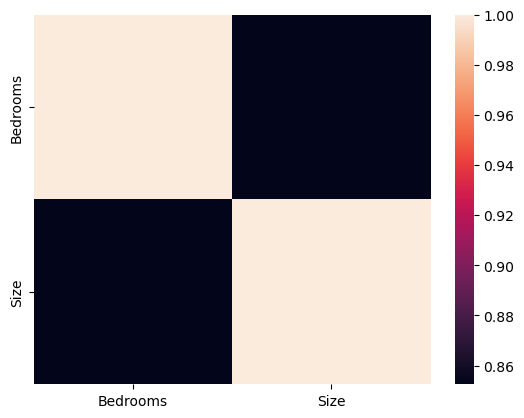

In [14]:
#removing Multicollinearity
corr = df.select_dtypes("number").drop(columns="Price").corr()
sns.heatmap(corr);

In [15]:
low, high = df["Price"].quantile([0.1, 0.9])
df = df[df["Price"].between(low, high)]


In [16]:
features = ["Size", "Neighborhood", "Bedrooms"]
target = "Price"

In [17]:
X = df[features]
y = df[target]

In [18]:
y_mean=y.mean()
y_pred_baseline = [y_mean] * len(y)

In [19]:
print("Mean apt price:", round(y_mean,2))

print("Baseline MAE:", mean_absolute_error(y,y_pred_baseline))

Mean apt price: 20148239.6
Baseline MAE: 13727637.77480401


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True, handle_unknown="ignore"), # Handle unknown towns safely
    SimpleImputer(strategy="mean"),
    Ridge()
)
model.fit(X_train, y_train)

C:\Users\mujta\anaconda3\Lib\site-packages\sklearn\externals\_numpydoc\docscrape.py:420: UserWarning: Unknown section Example
  self[section] = content


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('onehotencoder', ...), ('simpleimputer', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,verbose,0
,cols,['Neighborhood']
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'ignore'
,use_cat_names,True


In [22]:
print("Training MAE:", mean_absolute_error(y_train, model.predict(X_train)))
print("TEST MAE (The Real Score):", mean_absolute_error(y_test, model.predict(X_test)))

Training MAE: 2042573.0108653586
TEST MAE (The Real Score): 2092289.2995542656


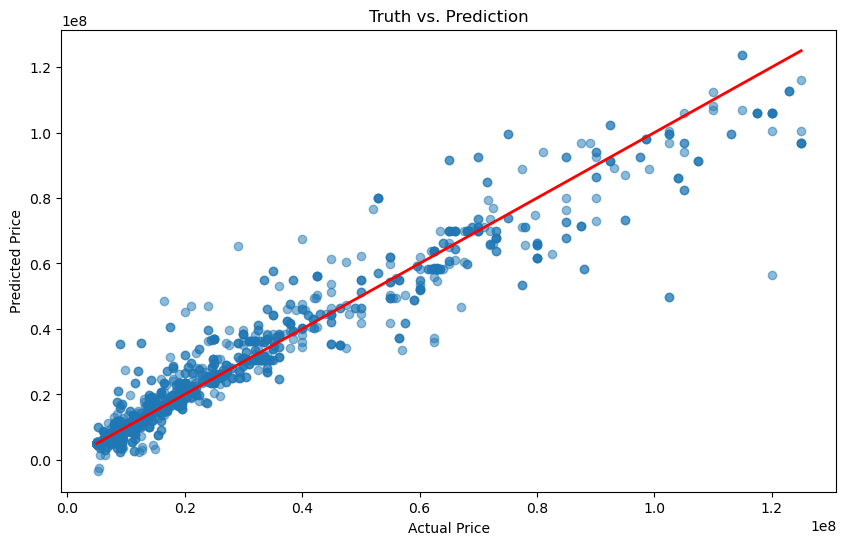

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, model.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Truth vs. Prediction")
plt.show()

In [24]:
def make_prediction(Size, Neighborhood, Bedrooms):
    data = {
        "Size": [Size],
        "Neighborhood": [Neighborhood],
        "Bedrooms": [Bedrooms],
     }
    df_input = pd.DataFrame(data)

    # Reorder columns exactly as training
    df_input = df_input[model.feature_names_in_]

    prediction = model.predict(df_input)[0]
    return f"Predicted apartment price: {prediction:.2f} PKR"


In [25]:
make_prediction(400,"DHA Phase 6 DHA Defence",6)

'Predicted apartment price: 86905649.49 PKR'

In [26]:
make_prediction(400,"Bahria Town - Precinct 10-A Bahria Town Karachi",6)

'Predicted apartment price: 57582993.22 PKR'

In [27]:
import joblib

neighborhoods = df["Neighborhood"].unique().tolist()
joblib.dump(neighborhoods, "neighborhoods.pkl")


['neighborhoods.pkl']

In [28]:
neighborhoods = joblib.load("neighborhoods.pkl")
print(neighborhoods)


['DHA Phase 6 DHA Defence', 'Bahria Town - Precinct 11-A Bahria Town - Precinct 11', 'Bahria Town - Precinct 10-A Bahria Town Karachi', 'Bahria Greens Bahria Town Karachi', 'Bahria Town Karachi Karachi', 'Lakhani Presidency Rashid Minhas Road', 'DHA Phase 5 DHA Defence', 'North Nazimabad - Block J North Nazimabad', 'Emaar Crescent Bay DHA Phase 8', 'DHA Phase 4 DHA Defence', 'Shah Faisal Town Karachi', 'Model Colony - Malir Malir', 'Gulshan-e-Iqbal - Block 10 Gulshan-e-Iqbal', 'Bahria Town - Precinct 19 Bahria Town Karachi', 'Bahria Heights Bahria Town Karachi', 'Navy Housing Scheme Karsaz Karachi', 'Askari 5 - Sector J Askari 5', 'Rahat Commercial Area DHA Phase 6', 'Bahria Paradise Bahria Town Karachi', 'North Nazimabad - Block K North Nazimabad', 'DHA Phase 7 DHA Defence', 'Bahria Town - Ali Block Bahria Town - Precinct 12', 'Bahria Town - Precinct 11-B Bahria Town - Precinct 11', 'Gulistan-e-Jauhar - Block 16-A Gulistan-e-Jauhar', 'KDA Scheme 1 Karachi', 'Askari 4 Gulistan-e-Jauhar

In [51]:
joblib.dump(model, "Karachi_house_Prediction.pkl")


['Karachi_house_Prediction.pkl']